# Part 2, Topic 1, Lab A: Instruction Power Differences (MAIN)

---
NOTE: This lab references some (commercial) training material on [ChipWhisperer.io](https://www.ChipWhisperer.io). You can freely execute and use the lab per the open-source license (including using it in your own courses if you distribute similarly), but you must maintain notice about this source location. Consider joining our training course to enjoy the full experience.

---

**SUMMARY:** *Now that you've been introduced to the ChipWhisperer platform, we'll be using it to learn more about how the power consumed by a microcontroller varies based on what operations it is performing and what instructions it is executing.*

**LEARNING OUTCOMES:**

* Capturing a power trace with ChipWhisperer
* Making connections between various simple instructions and power traces

## Prerequisites

Hold up! Before you continue, check you've done the following tutorials:

* ☑ Jupyter Notebook Intro (you should be OK with plotting & running blocks).
* ☑ SCA101 Intro (you should have an idea of how to get hardware-specific versions running).

## Setup

At this point you've got to insert code to perform the power trace capture. There are two options here:
* Capture from physical device.
* Read from a file.

You get to choose your adventure - see the two notebooks with the same name of this, but called `(SIMULATED)` or `(HARDWARE)` to continue. Inside those notebooks you should get some code to copy into the following section, which will define the capture function.

Be sure you get the `"✔️ OK to continue!"` print once you run the cell afterwards, otherwise things will fail later on!

In [1]:
SCOPETYPE = 'OPENADC'
PLATFORM = 'CWHUSKY'

In [2]:
%%bash
cd ../../../firmware/mcu
mkdir -p simpleserial-base-lab2 && cp -r simpleserial-base/* $_
cd simpleserial-base-lab2

In [3]:
%%bash -s "$PLATFORM"
cd ../../../firmware/mcu/simpleserial-base-lab2
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (Arm GNU Toolchain 13.2.rel1 (Build arm-13.7)) 13.2.1 20231009
Copyright (C) 2023 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWHUSKY 
.
Compiling:
-en     simpleserial-base.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/startup_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sam4s_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/uart.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pio.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/system_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sysclk.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pmc.c ...
-

In [4]:
import chipwhisperer as cw
try:
    if not scope.connectStatus:
        scope.con()
except NameError:
    scope = cw.scope()
   
try:
    target = cw.target(scope)
except IOError:
    print("INFO: Caught exception on reconnecting to target - attempting to reconnect to scope first.")
    print("INFO: This is a work-around when USB has died without Python knowing. Ignore errors above this line.")
    scope = cw.scope()
    target = cw.target(scope)

print("INFO: Found ChipWhisperer😍")

if "STM" in PLATFORM or PLATFORM == "CWLITEARM" or PLATFORM == "CWNANO":
    prog = cw.programmers.STM32FProgrammer
elif PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
    prog = cw.programmers.XMEGAProgrammer
elif "neorv32" in PLATFORM.lower():
    prog = cw.programmers.NEORV32Programmer
elif PLATFORM == "CW308_SAM4S" or PLATFORM == "CWHUSKY":
    prog = cw.programmers.SAM4SProgrammer
else:
    prog = None
    
import time
time.sleep(0.05)
scope.default_setup()

if PLATFORM == "CW308_SAM4S" or PLATFORM == "CWHUSKY":
    scope.io.target_pwr = 0
    time.sleep(0.2)
    scope.io.target_pwr = 1
    time.sleep(0.2)
def reset_target(scope):
    if PLATFORM == "CW303" or PLATFORM == "CWLITEXMEGA":
        scope.io.pdic = 'low'
        time.sleep(0.1)
        scope.io.pdic = 'high_z' #XMEGA doesn't like pdic driven high
        time.sleep(0.1) #xmega needs more startup time
    elif "neorv32" in PLATFORM.lower():
        raise IOError("Default iCE40 neorv32 build does not have external reset - reprogram device to reset")
    elif PLATFORM == "CW308_SAM4S" or PLATFORM == "CWHUSKY":
        scope.io.nrst = 'low'
        time.sleep(0.25)
        scope.io.nrst = 'high_z'
        time.sleep(0.25)
    else:  
        scope.io.nrst = 'low'
        time.sleep(0.05)
        scope.io.nrst = 'high_z'
        time.sleep(0.05)

INFO: Found ChipWhisperer😍
scope.gain.gain                          changed from 0                         to 22                       
scope.gain.db                            changed from 15.0                      to 25.091743119266056       
scope.adc.samples                        changed from 131124                    to 5000                     
scope.clock.clkgen_freq                  changed from 0                         to 7363636.363636363        
scope.clock.adc_freq                     changed from 0                         to 29454545.454545453       
scope.io.tio1                            changed from serial_tx                 to serial_rx                
scope.io.tio2                            changed from serial_rx                 to serial_tx                
scope.io.hs2                             changed from None                      to clkgen                   
scope.glitch.phase_shift_steps           changed from 0                         to 4592              

In [5]:
cw.program_target(scope, prog, "../../../firmware/mcu/simpleserial-base-lab2/simpleserial-base-{}.hex".format(PLATFORM))

In [13]:
proj = cw.create_project("./data/course_2_1")

def capture_trace(_ignored=None):
    ktp = cw.ktp.Basic()
    key, text = ktp.next()
    return cw.capture_trace(scope, target, text)

In [7]:
wave = capture_trace()
print("✔️ OK to continue!")

✔️ OK to continue!


(Personal) Function to speed-up graphing wave

In [8]:
from IPython.display import display
import matplotlib.pylab as plt
import numpy as np

def plot_waves(waves_data, adc_freq, num_of_samples):
    plt.clf()
    fig, ax = plt.subplots(figsize=(15,5))
    ax.set_xlabel("Time (ms)")
    ax.set_ylabel("ADC output (leakage signal)")
    ax.set_title("Power trace")
    ax.grid(True)
    time_domain = (np.arange(num_of_samples) / adc_freq) * (1e6)

    plotted_waves = []
    
    for (wave, description) in waves_data:
        #plt.plot(time_domain, wave, label=description, color=color)
        plotted_wave, = ax.plot(time_domain, wave, label=description)
        plotted_waves.append(plotted_wave)

    #plt.legend(loc="upper right", frameon=True, fancybox=True, shadow=True)
    #plt.show()
    
    leg = ax.legend()
    lined = {}
    
    #line1, = ax.plot(x, y1, label="sin(x)")
    #line2, = ax.plot(x, y2, label="cos(x)")

    for legline, origline in zip(leg.get_lines(), plotted_waves):
        legline.set_picker(True)  # Enable picking
        lined[legline] = origline

    def on_pick(event):
        legline = event.artist
        origline = lined[legline]
        visible = not origline.get_visible()
        origline.set_visible(visible)
        legline.set_alpha(1.0 if visible else 0.2)  # fade legend entry
        fig.canvas.draw()

    fig.canvas.mpl_connect("pick_event", on_pick)
    #display(fig)
    plt.show()

In [22]:
def record_wave():
    cw.program_target(scope, prog, "../../../firmware/mcu/simpleserial-base-lab2/simpleserial-base-{}.hex".format(PLATFORM))
    data = capture_trace()
    proj.traces.set(data)
    proj.save()
    return data.wave

## "Empty" Trace

As you saw in earlier labs, the `simpleserial-base` firmware echos what we send to it. For this lab, we just want to focus on simple instructions, rather than serial communication. Open `simpleserial-base.c` in the `simpleserial-base-lab2` folder, navigate to the `get_pt()` function, and remove the `simpleserial_put()` call.

Rebuild the firmware and upload it to the target. Capture a trace, and we can plot it using the following code:

In [23]:
%%bash -s "$PLATFORM"
cd ../../../firmware/mcu/simpleserial-base-lab2
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (Arm GNU Toolchain 13.2.rel1 (Build arm-13.7)) 13.2.1 20231009
Copyright (C) 2023 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWHUSKY 
.
Compiling:
-en     simpleserial-base.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/startup_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sam4s_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/uart.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pio.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/system_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sysclk.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pmc.c ...
-

In [24]:
wave1 = record_wave()

AttributeError: 'Traces' object has no attribute 'set'

In [ ]:
%matplotlib ipympl
plot_waves([(wave, "with simpleserial_put()"), (wave1, "without simpleserial_put()")], scope.clock.adc_freq, scope.adc.samples)

You shouldn't see much happening here before the target starts idling.

## Simple Instructions

To start off, let's insert some simple instructions to see if they're visible in the power trace. We're mostly looking for an instruction that executes in a single cycle, which will depend on what platform you're using for this lab. For an ARM device, try inserting the following code, which will execute 20 multiplies. It's important to mark `A` as `volatile` here to prevent the compiler from optimizing all these instructions out:

```C
	volatile long int A = 0x2BAA;
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;

	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
	A *= 2;
```

For the XMEGA/AVR, multiply is a more expensive instruction, so insert the following code instead:

```C

	volatile long int A = 0x2BAA;
	A += 2;
	A += 2;
	A += 2;
	A += 2;
	A += 2;
	
	A += 2;
	A += 2;
	A += 2;
	A += 2;
	A += 2;

	A += 2;
	A += 2;
	A += 2;
	A += 2;
	A += 2;
	
	A += 2;
	A += 2;
	A += 2;
	A += 2;
	A += 2;
```

Then rebuild, capture a new trace, and plot it:

In [97]:
%%bash -s "$PLATFORM"
cd ../../../firmware/mcu/simpleserial-base-lab2
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10.3-2021.10) 10.3.1 20210824 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWHUSKY 
.
Compiling:
-en     simpleserial-base.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/startup_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sam4s_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/uart.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pio.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/system_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sysclk.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pmc.c 

In [98]:
wave2 = record_wave()

(ChipWhisperer Target WARNING|File SimpleSerial.py:454) Unexpected start to command: z


Depending on your target, there might not be much difference here. You may want to plot both traces on the same plot:

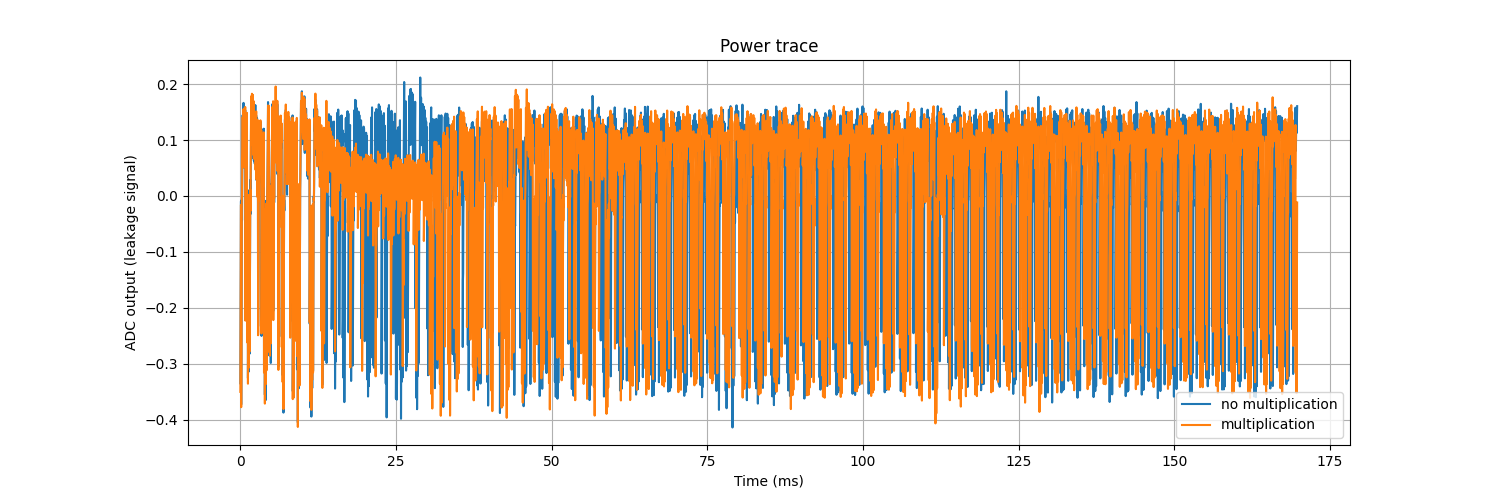

In [103]:
%matplotlib ipympl
plot_waves([(wave1, "no multiplication"), (wave2, "multiplication")], scope.clock.adc_freq, scope.adc.samples)

## Simple Instruction Loop

You might think that it's strange that we didn't simply use a loop instead of copying the same thing out 20 times. Rectify this by replacing these instructions with a loop. **Make sure to make the loop variable volatile as well.**

In [99]:
%%bash -s "$PLATFORM"
cd ../../../firmware/mcu/simpleserial-base-lab2
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10.3-2021.10) 10.3.1 20210824 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWHUSKY 
.
Compiling:
-en     simpleserial-base.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/startup_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sam4s_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/uart.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pio.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/system_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sysclk.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pmc.c 

In [100]:
wave3 = record_wave()

(ChipWhisperer Target WARNING|File SimpleSerial.py:454) Unexpected start to command: z


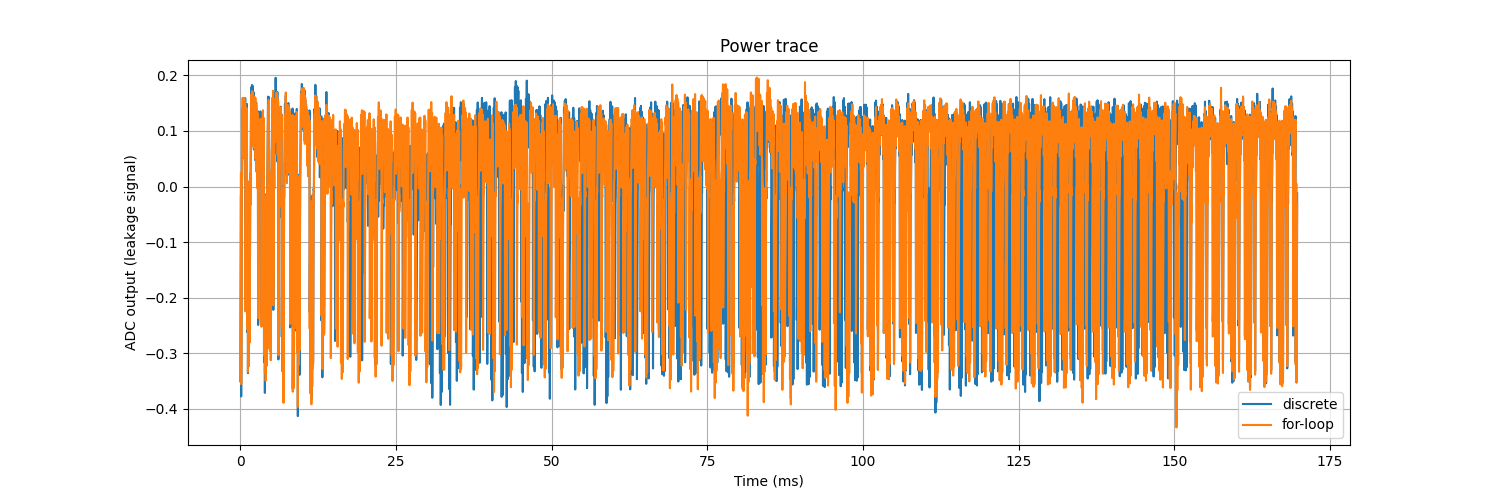

In [104]:
%matplotlib ipympl
plot_waves([(wave2, "discrete"), (wave3, "for-loop")], scope.clock.adc_freq, scope.adc.samples)

Are you surprised by how different the loop is from just repeatedly performing operations? If you're comfortable with assembly, you can check the `.lss` file in the `simpleserial-base-lab2` directory. Otherwise, here's a C level overview of what (depending on how your compiler lays things out) the loop acutally looks like:

```C
i=0;
start:
    if (i > 20) {
        goto end;
    }    
    A *= 2;
    i += 1;
    goto start;
end:
    trigger_low();
    //...
```

As you can see, the microcontroller has to do a lot more than simply repeating our instruction. As such, it's something a compiler will often "unroll" (basically turn it back into our original repeated multiplies). In our case, since `i` was marked as `volatile`, the compiler avoided making this optimization. Unrolling loops also increases code size, so the compiler might also avoid unrolling when optimizing for code size.

## Expensive Instructions

Up to now, all the instructions we've used (besides branches in the loop) have executed in a single clock cycle. Instead, let's try an instruction that takes multiple clock cycles to execute. This will be platform specific, but for an ARM device, a divide will work well. The AVR/XMEGA doesn't actually have a divide instruction, so you'll want to use something like a multiply instead.

In [108]:
%%bash -s "$PLATFORM"
cd ../../../firmware/mcu/simpleserial-base-lab2
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10.3-2021.10) 10.3.1 20210824 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWHUSKY 
.
Compiling:
-en     simpleserial-base.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/startup_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sam4s_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/uart.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pio.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/system_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sysclk.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pmc.c 

In [109]:
wave4 = record_wave()

(ChipWhisperer Target WARNING|File SimpleSerial.py:454) Unexpected start to command: z


/var/folders/1s/yy2fj15x0jn7c5g4qr9r7kl00000gn/T/ipykernel_28577/2758369356.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(15,5))


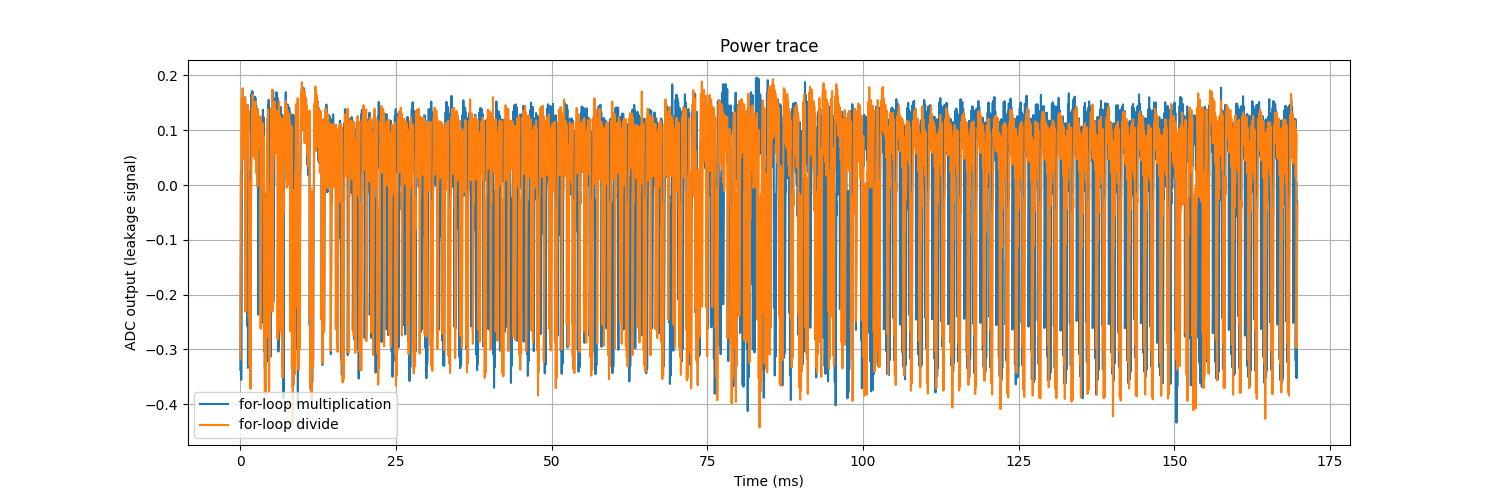

In [110]:
%matplotlib ipympl
plot_waves([(wave3, "for-loop multiplication"), (wave4, "for-loop divide")], scope.clock.adc_freq, scope.adc.samples)

In [113]:
%%bash -s "$PLATFORM"
cd ../../../firmware/mcu/simpleserial-base-lab2
make PLATFORM=$1 CRYPTO_TARGET=NONE

SS_VER set to SS_VER_1_1
SS_VER set to SS_VER_1_1
.
Welcome to another exciting ChipWhisperer target build!!
arm-none-eabi-gcc (GNU Arm Embedded Toolchain 10.3-2021.10) 10.3.1 20210824 (release)
Copyright (C) 2020 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.

mkdir -p objdir-CWHUSKY 
.
Compiling:
-en     simpleserial-base.c ...
-e Done!
.
Compiling:
-en     .././simpleserial/simpleserial.c ...
-e Done!
.
Compiling:
-en     .././hal/hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/startup_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sam4s_hal.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/uart.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pio.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/system_sam4s.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/sysclk.c ...
-e Done!
.
Compiling:
-en     .././hal//sam4s/pmc.c 

In [112]:
wave5 = record_wave()

(ChipWhisperer Target WARNING|File SimpleSerial.py:454) Unexpected start to command: z


In [114]:
wave6 = record_wave()

(ChipWhisperer Target WARNING|File SimpleSerial.py:454) Unexpected start to command: z


In [116]:
wave7 = record_wave()

(ChipWhisperer Target WARNING|File SimpleSerial.py:454) Unexpected start to command: z


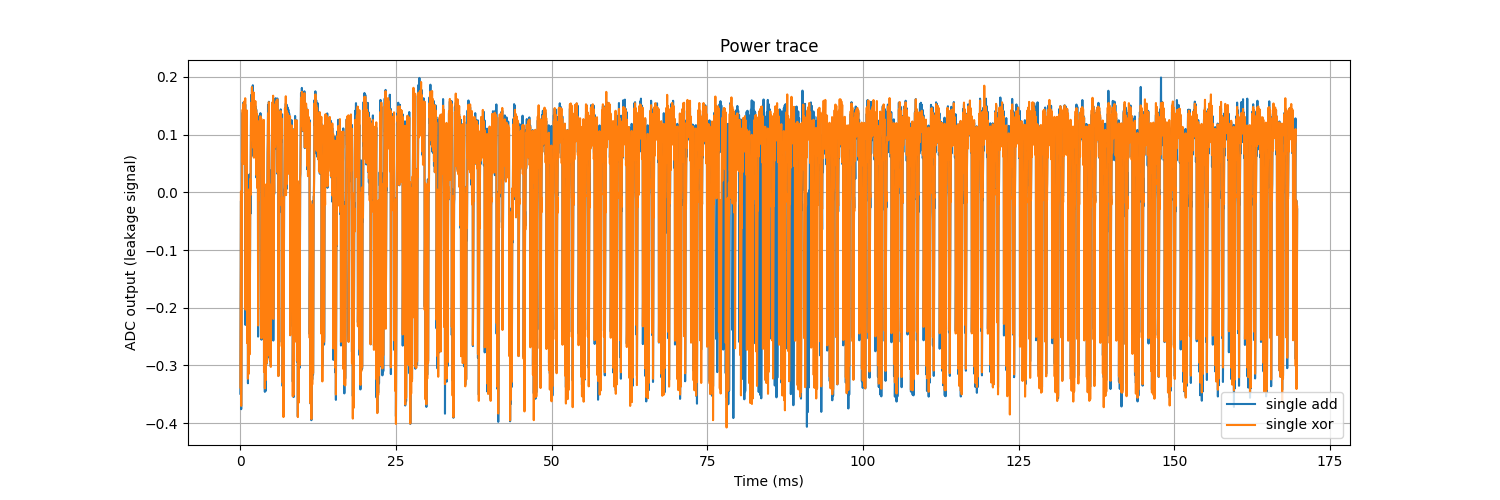

In [118]:
%matplotlib ipympl
plot_waves([(wave5, "single add"), (wave6, "single xor")], scope.clock.adc_freq, scope.adc.samples)

You can probably see a similar pattern to the faster instruction, but each go through the loop takes longer. We would also expect that longer instructions would also consume more power. Can you see this in your plot?

**HINT: In order to measure current, ChipWhisperer measures voltage drop across a shunt resistor. This means that the power trace is actually inverted (aka large negative swings are areas of higher power consumption).**

## Conclusions & Next Steps

By now you should be reasonably convinced that we can gain some understanding of what a microcontroller is doing by looking at its power consumption. Going forward, we'll be focusing on more objective measurements, but what we did in this lab is still very valuable. AES implementations, for example, will often have a very distinct shape. You can use this to help identify what an unknown device is doing at different times.

Of course, there's a lot more you can do with this lab. For example, does an add look any different from an XOR? Next time, we'll be using what we learned in this lab to break a simple password check.

In [121]:
scope.dis()
target.dis()

(ChipWhisperer Scope ERROR|File naeusbchip.py:113) Scope already disconnected!


---
<small>NO-FUN DISCLAIMER: This material is Copyright (C) NewAE Technology Inc., 2015-2020. ChipWhisperer is a trademark of NewAE Technology Inc., claimed in all jurisdictions, and registered in at least the United States of America, European Union, and Peoples Republic of China.

Tutorials derived from our open-source work must be released under the associated open-source license, and notice of the source must be *clearly displayed*. Only original copyright holders may license or authorize other distribution - while NewAE Technology Inc. holds the copyright for many tutorials, the github repository includes community contributions which we cannot license under special terms and **must** be maintained as an open-source release. Please contact us for special permissions (where possible).

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY, FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM, OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE SOFTWARE.</small>